# Example analysis

> **Goal:** analyze *all* sources that are well-resolved for morphology ($R_p$ > seeing, not stars)
> 
There are many useful catalogs that could help select a sample:

* Curve-of-growth based Source Extractor catalogs
    * `cfis/tiles_DR5/CFIS.XXX.YYY.r.cog.cat`
    * Contain X, Y coordinates of every source as well as R.A. and Dec, photometry in differently-sized apertures, radii, and so on
*  Photometric redshift catalog
    * `cfis/gaap/UNIONS.XXX.YYY._ugri[z]_photoz_ext.cat`
    * Photo-zs from the KiDS pipeline an ML-based. Also have R.A. and Dec of very target so a cross-match is fairly easy
* Star-galaxy separation based on [this guide](https://unions.skysurvey.cc/Dataset/sourceclass)
    * `cfis/Processed_catalogues/StellarClass/stargal.cfis.r.dr5/tile.cats/CFIS.XXX.YYY.r.sg.fits`
    * Only R.A. and Dec, again a cross-match is possible
    * Pretty easy to derive the equivalent metric by hand, faster than doing the cross-match

#### Imports

In [4]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats

import sys
sys.path.append('../')
from lib.io import download_files, make_cutout, parse_morph
from lib.plotting import plot_cutouts
from statmorph_lsst import SourceMorphology
from statmorph_lsst.utils import make_figure

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fetching data

Load the list of tiles, select one, and download data. <br>
`download_files` takes the tilename in `XXX.YYY` format and fetches the tile along with any required additional files (segmap, weightmap, photo-z catalog, etc.)

In [6]:
tile_list = pd.read_csv('../catalogs/tiles_r.csv')
tile_list.head(2)
tilename = tile_list.iloc[0].tile[-9:-2]

download_files(tilename, tile=True, catalog=True, weightmap=True, segmap=True, photoz=False, star_galaxy=True)
# download_files(tile, tile=False, catalog=False, weightmap=False, segmap=False, photoz=False, star_galaxy=True)

## Selecting a sample

**1.** After some trial-and-error, since we are not looking for UFDs or anything like this, it's actually the easiest to just select good large galaxies using the Source Extractor catalog and a cut on `FLUX_RADIUS` (half-light radius). To select our sample, we do:

* `FLUX_RADIUS > 5` (this is about the typical seeing and seems to select objects that are large enough)
* `FLAG != 19`: there are many satellite streaks but they are flagged as 19 (thanks Stephen Gwynn!)
* `FLAG != 58`: flag for chip gaps
 

**2.** We also add a surface brightness cut to get rid of bright stars (while keeping bright galaxies). We define a surface brightness proxy as `SB = MAG_COG - 5 log FLUX_RADIUS` and add a cut
* `SB > 10` and `SB < 18` (really low SB objects are mostly artifacts; potentially they are UDGs but we can't run the bar detection on them anyway)

**3.** There are some stellite streak - chip gap looking things that persist after these flags, so we also define an axis ratio, `Q = B_WORLD/A_WORLD`. We remove anything with 

* `Q < 0.1`

This should keep edge-on galaxies which we don't really want for this project but it might be useful to have them in the future

**4.** There are some sources with bad `MAG_COG` measurements and some are too faint to be useful so we restrict

* `MAG_COG` < 28 (this is really pushing UNIONS detection limit anyway)

**5.** We use the star-galaxy separation catalog (matched on row index) to remove stars as much as possible:

* `M1-M2 < 1.5`
* `M1-M2 > -0.5` (these two remove some bad detections with invalid M1 and M2 values)
* `MAG_COG < 16.5` (basically everything above that are saturated stars and we're not interested in super local galaxies)
* `0.63 < M1-M2 < 0.75` for `MAG_COG < 23.5`

In [7]:
def select_sample(tile, plot=False):

    # Load the source extractor and star-galaxy catalogs
    cat = Table.read(f'/scratch/cat_{tile}.cat', format='ascii').to_pandas()
    sg = Table.read(f'/scratch/sg_{tile}.cat').to_pandas()[['M1','M2','M3','s21','s31']]
    cat = pd.merge(cat, sg, left_index=True, right_index=True)

    # Calculate surface brightness and axis ratio proxies
    cat['SB'] = cat.MAG_COG - 5*np.log10(cat.FLUX_RADIUS)
    cat['Q'] = cat['B_WORLD']/cat['A_WORLD']
    
    # Apply criteria above
    good = ((cat.FLUX_RADIUS >= 4) &
            (cat.FLAGS < 17) &
            # (cat.SB >= 10) &
            # (cat.SB <= 30) &
            (cat.Q >= 0.05) &
            (cat.MAG_COG <= 27) &
            (cat.MAG_COG >= 14) &
            (cat.M1-cat.M2 < 1.5) &
            (cat.M1-cat.M2 > 0.5) &
            (cat.SB <= 20)
           )
    
    # Also from the star-galaxy catalog
    stars = (cat.MAG_COG < 23.5) & (cat.M1-cat.M2 >= 0.63) & (cat.M1-cat.M2 < 0.75)
    stars = (cat.s21 < 3) | (cat.s31 < 3)
    
    # Plot the selected sample
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(8,5))
        plt.scatter(cat.MAG_COG, cat.M1-cat.M2, s=1, alpha=0.1, c='k')
        plt.scatter(cat[good].MAG_COG, cat[good].M1-cat[good].M2, s=1, alpha=0.5, c='b')
        plt.scatter(cat[stars].MAG_COG, cat[stars].M1-cat[stars].M2, s=1, alpha=0.5, c='r')
        plt.xlim(14, 28)
        plt.ylim(-0.5, 1.5)
        plt.colorbar()

    good = good & ~stars
        
    print(f'{np.sum(good)} galaxies in the tile')
    return cat, cat[good]

In [8]:
cat, sample = select_sample(tilename, plot=False)

636 galaxies in the tile


/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Make a few cutouts to show that they are indeed galaxies

/tmp/ipykernel_9699/3729208286.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(-2.5*np.log10(np.abs(img)/pxscale**2)+30, vmin=19, vmax=27, cmap='gray')


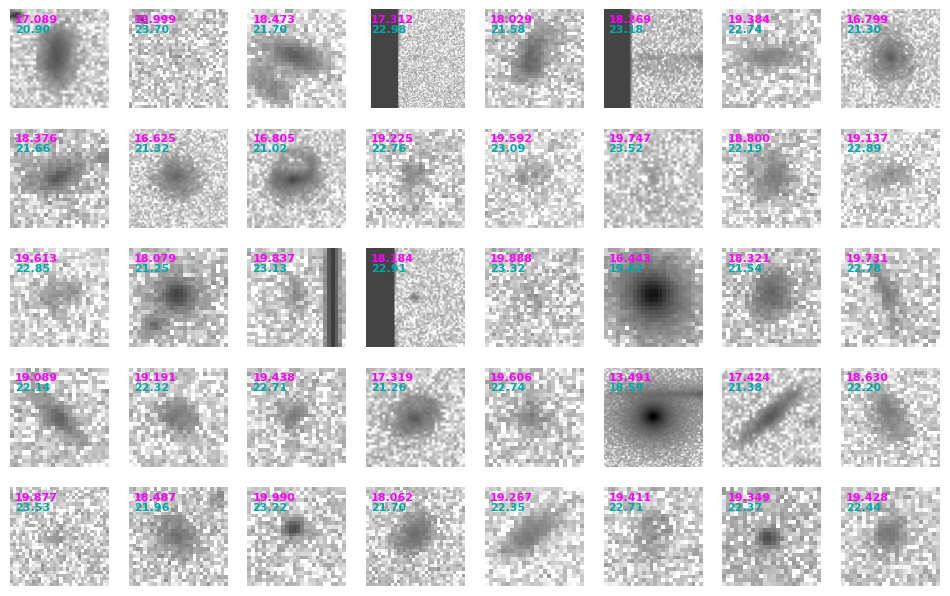

In [9]:
tile_f = fits.open(f'/scratch/tile_{tilename}.fits')

fig, axs = plt.subplots(5,8,figsize=(1.5*8, 1.5*5))
axs = axs.flatten()

subset = sample if len(sample)<40 else sample.sample(40)
pxscale = 0.1857 
for i in range(len(subset)):
    
    ax = axs[i]
    row = subset.iloc[i]
    xc, yc = int(row.X_IMAGE+0.5), int(row.Y_IMAGE+0.5)
    size = int(3*row.FLUX_RADIUS)
    
    img = tile_f[0].data[yc-size:yc+size, xc-size:xc+size]
    ax.imshow(-2.5*np.log10(np.abs(img)/pxscale**2)+30, vmin=19, vmax=27, cmap='gray')
    ax.annotate(f'{row.SB:0.3f}', xy=(0.05, 0.95), xycoords='axes fraction', color='#f0f', size=8, ha='left', va='top', weight=800)
    ax.annotate(f'{row.MAG_COG:0.2f}', xy=(0.05, 0.85), xycoords='axes fraction', color='#0aa', size=8, ha='left', va='top', weight=800)
    
for ax in axs:
    ax.axis('off')

tile_f.close()

## Prepare other files

* Weight map
* Mask - we can derive from the weightmap
* Segmentation map - use the premade one
* PSF - use the empirical PSF from Stephen Gwynn and scale by seeing

Load all the other files:

In [12]:
tile_f = fits.open(f'/scratch/tile_{tilename}.fits')
weightmap_f = fits.open(f'/scratch/wht_{tilename}.fits')
segmap_f = fits.open(f'/scratch/seg_{tilename}.fits')

Select a galaxy:

/arc/home/esazonova/unions-morph/nbs/../lib/plotting.py:11: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(-2.5*np.log10(np.abs(img)/pxscale**2)+zp, origin='lower', cmap='gray', vmin=19, vmax=27)


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

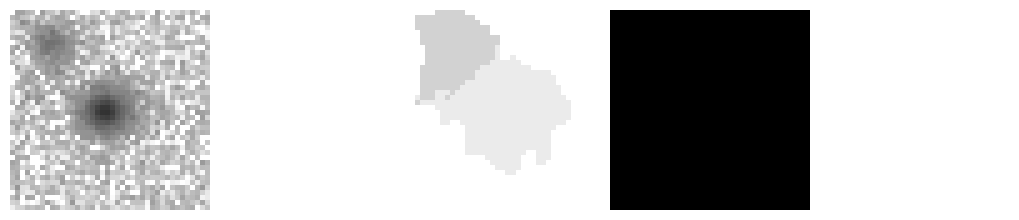

In [13]:
galaxy = sample.sample(n=1).iloc[0]
img, err, segmap, mask, psf, bgsd = make_cutout(galaxy, tile_f, weightmap_f, segmap_f, r_frac=4)

# Plot the images
plot_cutouts([img, err, segmap, mask, psf], zp=30, pxscale=0.1857)

Run statmorph:

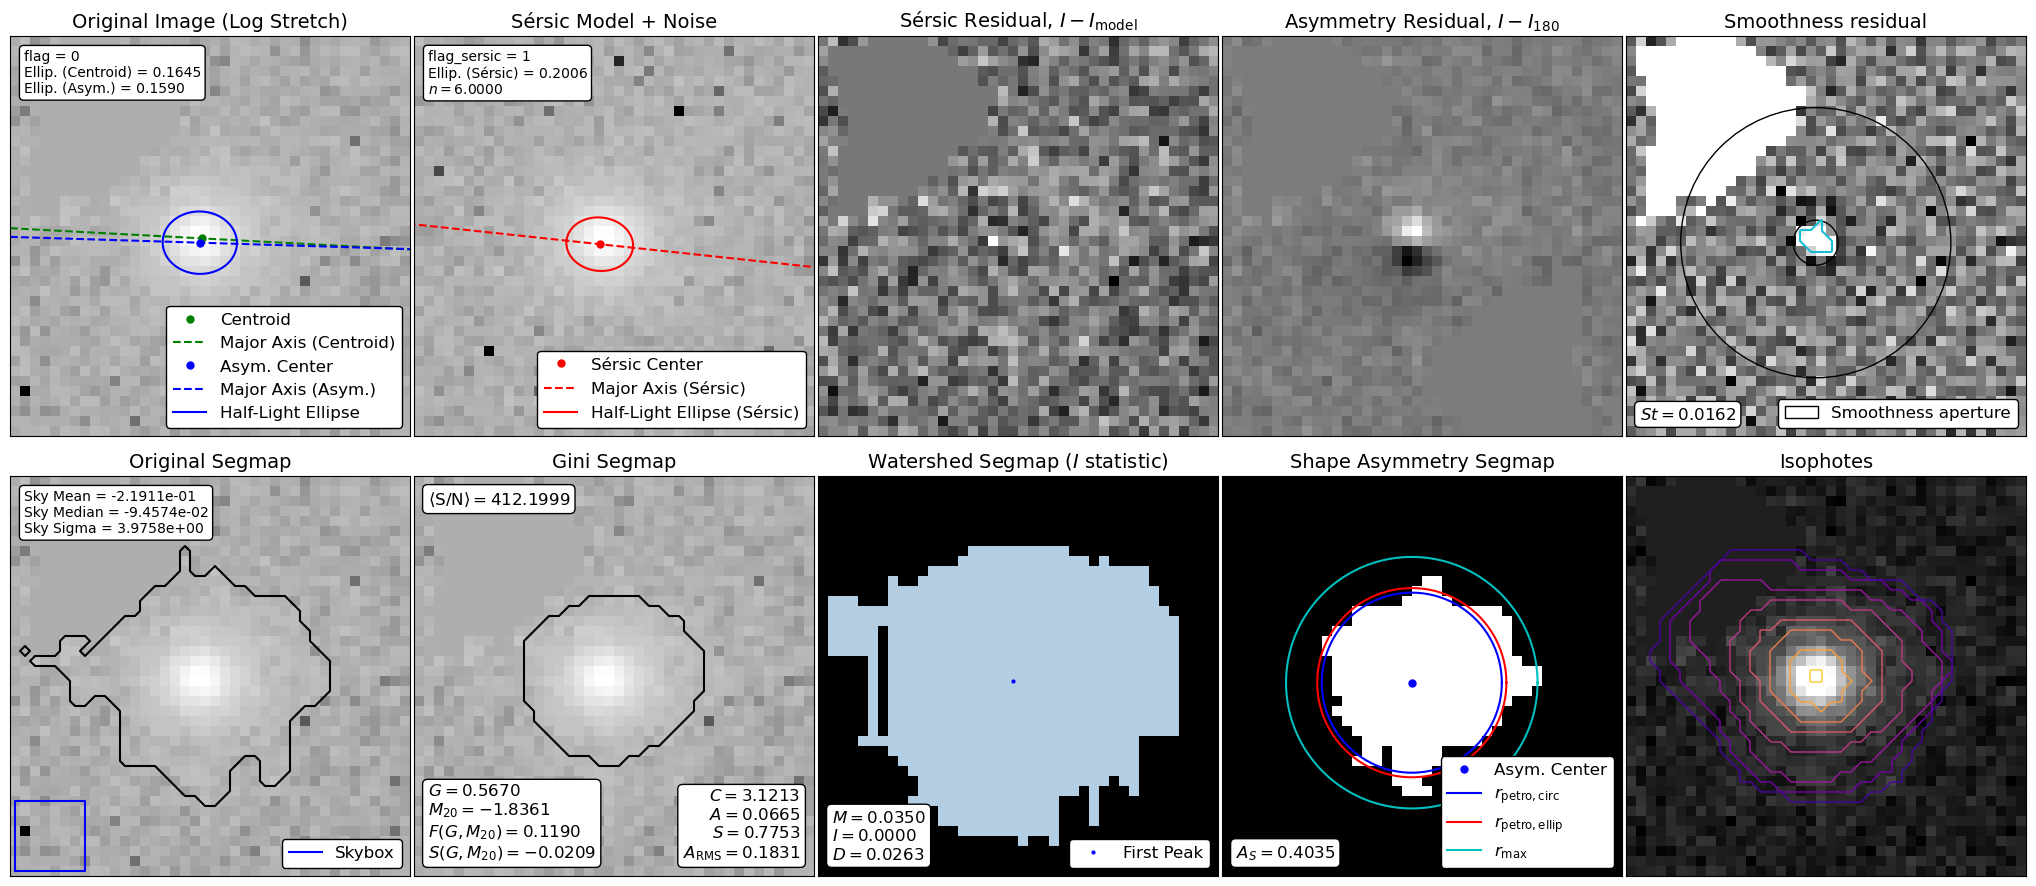

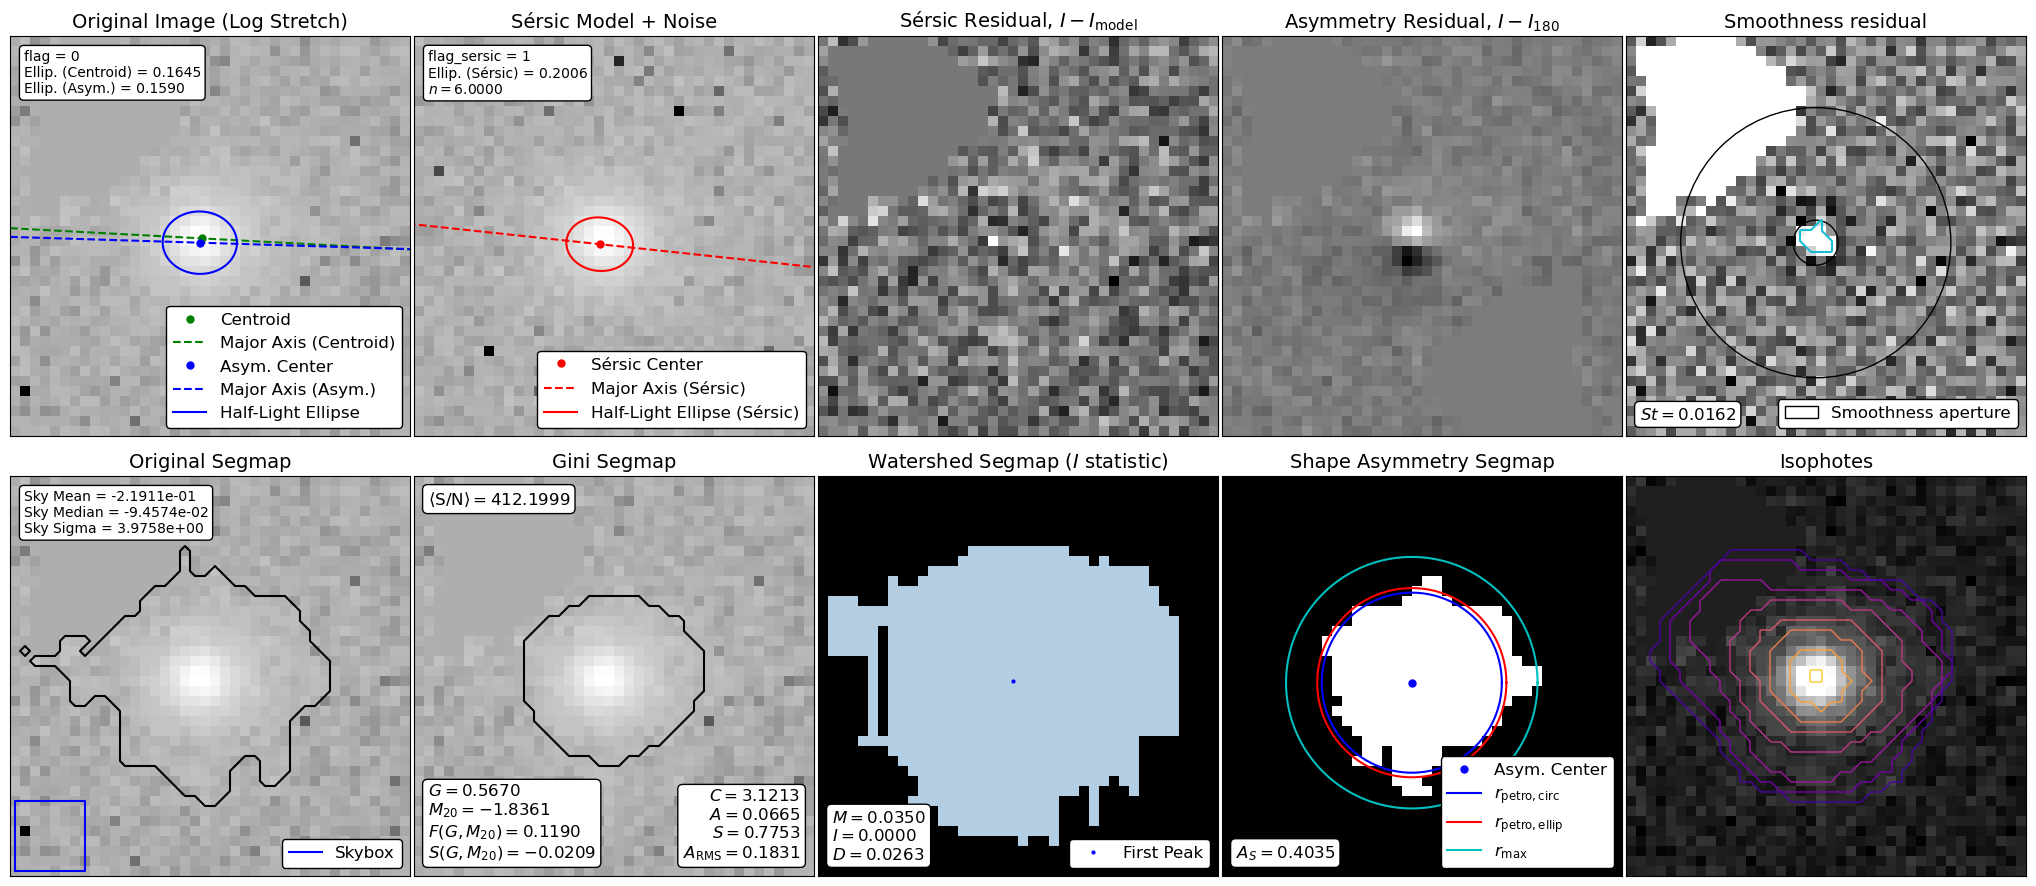

In [14]:
isophotes = np.arange(22, 26.5, 0.5)
fluxes = pxscale**2 * np.power(10, -(isophotes-30)/2.5)
morph = SourceMorphology(img, segmap, label=1, weightmap=err, mask=mask, psf=psf, interpolate_mask=False, asymmetry_isophotes=fluxes,
                        sersic_model_args={'bounds' : {'n' : (0.1, 6)}})
res = {'tile' : tilename, 'galaxy' : galaxy.name, 'ra': galaxy['ALPHA_J2000'], 'dec' : galaxy['DELTA_J2000'], 'fwhm' : galaxy.PREDIQ}
res = parse_morph(res,morph)
make_figure(morph)

In [30]:
tmp = pd.read_csv('../catalogs/morph.csv')

In [34]:
tmp.tile.value_counts()

tile
21.229    46
21.230    46
22.229    38
23.229    38
21.253    37
          ..
19.248     1
19.254     1
19.247     1
3.232      1
20.254     1
Name: count, Length: 905, dtype: int64